In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X_train = pd.read_csv(f"/opt/ml/processing/output/train/train.csv")
X_test = pd.read_csv(f"/opt/ml/processing/output/test/test.csv")
y_train = pd.read_csv(f"/opt/ml/processing/output/train/train_labels.csv")
y_test = pd.read_csv(f"/opt/ml/processing/output/test/test_labels.csv")

In [ ]:
# Drop user_id, lock_id from all pandas dataframes

X_train = X_train.drop(['user_id', 'lock_id', 'access_granted', 'is_weekend', 'is_business_hours', 'access_level', 'failed_attempts', 'time_of_day'], axis=1)
X_test = X_test.drop(['user_id', 'lock_id', 'access_granted', 'is_weekend', 'is_business_hours', 'access_level', 'failed_attempts', 'time_of_day'], axis=1)

In [ ]:
%set_env MLFLOW_TRACKING_URI=arn:aws:sagemaker:eu-central-1:559317267498:mlflow-tracking-server/mlflow-experiments
%set_env MLFLOW_EXPERIMENT_NAME=anomaly-detection-kmeans
%set_env AWS_PROFILE=AWSAdministratorAccess-559317267498

In [ ]:
X_train

In [ ]:
import mlflow
import numpy as np

#@remote(instance_type="ml.m5.xlarge")
def train_kmeans(X_train, n_clusters=5, random_state=42):
    import mlflow
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    
    # Enable autologging
    mlflow.sklearn.autolog()
    
    with mlflow.start_run(run_name="kmeans_clustering"):
        # Initialize and train KMeans
        kmeans = KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=random_state
        )
        
        # Fit the model
        kmeans.fit(X_train)
        
        # Get cluster assignments
        cluster_labels = kmeans.predict(X_train)
        
        # Calculate clustering metrics
        silhouette = silhouette_score(X_train, cluster_labels)
        calinski = calinski_harabasz_score(X_train, cluster_labels)
        inertia = kmeans.inertia_
        
        # Log metrics
        mlflow.log_metrics({
            "silhouette_score": silhouette,
            "calinski_harabasz_score": calinski,
            "inertia": inertia
        })
        
        # Log cluster distribution
        cluster_sizes = np.bincount(cluster_labels)
        for i, size in enumerate(cluster_sizes):
            mlflow.log_metric(f"cluster_{i}_size", int(size))
            mlflow.log_metric(f"cluster_{i}_percentage", size / len(X_train) * 100)
        
        # Calculate and log cluster centers
        for i, center in enumerate(kmeans.cluster_centers_):
            mlflow.log_metrics({
                f"cluster_{i}_center_{j}": val 
                for j, val in enumerate(center)
            })
        
        return kmeans, cluster_labels

def find_optimal_k(X_train, k_range=range(2, 11)):
    """Find optimal number of clusters using elbow method and silhouette score"""
    import mlflow
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    
    with mlflow.start_run(run_name="kmeans_optimization"):
        inertias = []
        silhouette_scores = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X_train)
            
            # Calculate metrics
            inertia = kmeans.inertia_
            silhouette = silhouette_score(X_train, kmeans.labels_)
            
            inertias.append(inertia)
            silhouette_scores.append(silhouette)
            
            # Log metrics for each k
            mlflow.log_metrics({
                f"k_{k}_inertia": inertia,
                f"k_{k}_silhouette": silhouette
            })
        
        # Find optimal k using elbow method
        # Calculate the differences between consecutive inertias
        inertia_diffs = np.diff(inertias)
        # Calculate the differences of differences to find the elbow point
        inertia_diffs2 = np.diff(inertia_diffs)
        # The elbow point is where the second derivative is maximum
        optimal_k = k_range[np.argmax(inertia_diffs2) + 1]

        fig = plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertias, 'bo-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)

        mlflow.log_figure(fig, "cluster_inertia.png")
        mlflow.log_param("optimal_k", optimal_k)
        
        return optimal_k, inertias, silhouette_scores

def analyze_clusters(X_train, cluster_labels, feature_names):
    """Analyze cluster characteristics"""
    import pandas as pd
    import mlflow
    
    with mlflow.start_run(run_name="cluster_analysis"):
        # Create DataFrame with features and cluster labels
        df_clustered = pd.DataFrame(X_train, columns=feature_names)
        df_clustered['Cluster'] = cluster_labels
        
        # Calculate cluster profiles
        cluster_profiles = df_clustered.groupby('Cluster').mean()
        
        # Log cluster profiles
        for cluster in cluster_profiles.index:
            for feature in feature_names:
                mlflow.log_metric(
                    f"cluster_{cluster}_{feature}_mean", 
                    cluster_profiles.loc[cluster, feature]
                )
        
        return cluster_profiles

# Main execution function
def run_clustering_analysis(X_train, feature_names):
    # Find optimal number of clusters
    optimal_k, inertias, silhouette_scores = find_optimal_k(X_train)

    # Train final model with optimal k
    kmeans_model, cluster_labels = train_kmeans(X_train, n_clusters=optimal_k)
    
    # Analyze clusters
    cluster_profiles = analyze_clusters(X_train, cluster_labels, feature_names)
    
    return kmeans_model, cluster_labels, cluster_profiles


In [ ]:
# Get feature names from X_train
feature_names = X_train.columns.tolist()

# Run clustering analysis
model, labels, profiles = run_clustering_analysis(X_train, feature_names)

# Print summary
print("\nCluster Profiles:")
print(profiles)

print("\nCluster Sizes:")
print(pd.Series(labels).value_counts().sort_index())

In [ ]:
def visualize_clusters_2d(X, labels, method='pca', title=None, save_path=None, centroids=None, sample_ids=None):
    """
    Visualize clusters in 2D using either PCA or t-SNE
    
    Parameters:
    -----------
    X : array-like
        Features matrix
    labels : array-like
        Cluster labels
    method : str, default='pca'
        Dimensionality reduction method ('pca' or 'tsne')
    title : str, optional
        Plot title
    save_path : str, optional
        Path to save the plot
    """
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import seaborn as sns
    
    # Reduce dimensionality
    if method.lower() == 'pca':
        reducer = PCA(n_components=2)
        X_2d = reducer.fit_transform(X)
        method_name = 'PCA'
    else:
        reducer = TSNE(n_components=2, random_state=42)
        X_2d = reducer.fit_transform(X)
        method_name = 't-SNE'
    
    # Create DataFrame for plotting
    df_plot = pd.DataFrame({
        'x': X_2d[:, 0],
        'y': X_2d[:, 1],
        'Cluster': labels
    })
        
    # Set up the plot style
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1) = plt.subplots(1, 1)    
    # Create scatter plot
    sns.scatterplot(data=df_plot, x='x', y='y', hue='Cluster', 
                    palette='deep', s=50, alpha=0.7)

    # Add centroids if provided
    if centroids is not None and method.lower() == 'pca':
        centroids_2d = reducer.transform(centroids)
        ax1.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                   c='black', marker='x', s=100, linewidths=3, 
                   label='Centroids')

    # Annotate points if requested
    if sample_ids is not None:
        ax1.scatter(X_2d[sample_ids, 0], X_2d[sample_ids, 1], 
                c='red', marker='x', s=15, linewidths=1, 
                label='anomalies')
           
    # Add titles and labels
    plt.title(title or f'Cluster Visualization using {method_name}')
    plt.xlabel(f'{method_name} Component 1')
    plt.ylabel(f'{method_name} Component 2')
    
    # Add legend
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Show plot
    plt.show()


In [208]:
X_test_pred = model.predict(X_test)
X_test_dist = model.transform(X_test)
X_test_anomaly_indexes = y_test[y_test['is_anomaly']==1].index.to_list()

dist_to_centroid = [dist_list[ind] for ind, dist_list in zip(X_test_pred, X_test_dist)]
threshold = np.percentile(dist_to_centroid, 95)
print(f"Threshold: {threshold}")
# get max_values index above threshold
anomaly_idx = np.where(dist_to_centroid > threshold)[0]
print(len(anomaly_idx))
print(len(X_test_anomaly_indexes))

# count number of matching ids between anomaly_idx and X_train_anomaly_indexes
print(len(np.intersect1d(anomaly_idx, X_test_anomaly_indexes)))

Threshold: 0.19348632578009345
100
96
93


2024/12/16 19:27:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '31ceafa85a43441cb4b007fd8802e0fe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/16 19:27:05 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/16 19:27:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run mercurial-squid-276 at: https://eu-central-1.experiments.sagemaker.aws/#/experiments/5/runs/31ceafa85a43441cb4b007fd8802e0fe
🧪 View experiment at: https://eu-central-1.experiments.sagemaker.aws/#/experiments/5


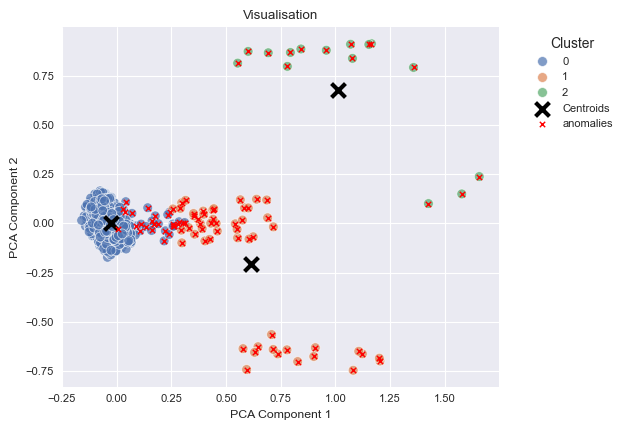

In [ ]:
visualize_clusters_2d(X_test, X_test_pred, title='Visualisation', centroids=profiles) #, sample_ids=X_test_anomaly_indexes)